In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

# (Q)ITE with analytically constructed states

In [2]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)

H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
print('Eigen energies:', eigvals_sorted)
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]
psi0 = eigvecs_sorted[0]


Eigen energies: [-17.03214083 -16.72269436 -15.72269436 ...  12.80422607  13.
  14.        ]


# QITE

In [3]:
results = load_data('data/benchmarks_manual_2nd_B=0.5_03-20-20')

In [4]:
indices = [0,2,4] # GC
#indices = [1,3,4] # HOPF

mid_id_ls = [1,2,4]
beta_lists_qite = {1:results[indices[0]]["evolution_times"],2:results[indices[1]]["evolution_times"],4:results[indices[2]]["evolution_times"]}
energy_dict_qite = {1:results[indices[0]]["optimal_energies"],2:results[indices[1]]["optimal_energies"],4:results[indices[2]]["optimal_energies"]}
fluctuation_dict_qite = {1:results[indices[0]]["variances"],2:results[indices[1]]["variances"],4:results[indices[2]]["variances"]}

fidelity_dict_qite = {}

beta_max_qite = np.max([np.max(beta_lists_qite[i]) for i in mid_id_ls])

psi = eigvecs_sorted[0]

states = results[0]["statevectors"]
energies = results[0]["optimal_energies"]

for i in range(3):
    fidelities = []

    psi = eigvecs_sorted[mid_id_ls[i]]
    states = results[indices[i]]["statevectors"]

    for phi in states:
        fidelities.append(np.abs(np.dot(psi.transpose()[0],phi))**2)
    fidelity_dict_qite[mid_id_ls[i]] = fidelities



## ITE

In [5]:
def compute_moments(psi, H):
    E = (psi.conj().T @ H @ psi)[0,0].real
    S = (psi.conj().T @ H @ H @ psi)[0,0].real
    return E, S, S - E**2

beta_list = [0]+np.linspace(0.01,7,80).tolist()

epsilon = 0.001
alpha = 0.5
energy_dict = dict()
fluctuation_dict = dict()
fidelity_dict = dict()
mid_id_ls = [1,2,4]
for mid_id in mid_id_ls:
    results_psi = []
    psi = eigvecs_sorted[10] + alpha*eigvecs_sorted[mid_id] + epsilon*eigvecs_sorted[0]
    psi = psi/np.linalg.norm(psi)
    fidelity_ls = []
    print(np.vdot(psi0, psi))
    initial_moment = compute_moments(psi, H_matrix)
    print(f'|E10>+{alpha}|E{mid_id}>+{epsilon}|E0>:Initial energy {initial_moment[0]}, fluctuation {initial_moment[-1]}')
    for beta in beta_list:
        psi_beta = scipy.linalg.expm(-beta*H_matrix).dot(psi)
        psi_beta = psi_beta / np.linalg.norm(psi_beta)
        fidelity_ls.append(np.vdot(psi0, psi_beta))
        results_psi.append(compute_moments(psi_beta, H_matrix))
    energies_psi = [r[0] for r in results_psi]
    fluctuation_psi = [r[-1] for r in results_psi]
    energy_dict[mid_id]=energies_psi
    fluctuation_dict[mid_id]=fluctuation_psi
    fidelity_dict[mid_id] = fidelity_ls


def state_to_dm(psi):
    # column vector
    psi = psi.reshape(-1, 1)
    return psi @ psi.conj().T

def fidelity(rho, sigma) -> float:
    sqrt_rho = scipy.linalg.sqrtm(rho)
    return (np.trace(scipy.linalg.sqrtm(sqrt_rho @ sigma @ sqrt_rho)).real)**2

(0.000894426833229287+0j)
|E10>+0.5|E1>+0.001|E0>:Initial energy -13.831080861623466, fluctuation 2.090367380749285
(0.0008944268332293642+0j)
|E10>+0.5|E2>+0.001|E0>:Initial energy -13.631081021623338, fluctuation 1.0937228115116966
(0.0008944268332292867+0j)
|E10>+0.5|E4>+0.001|E0>:Initial energy -13.431081181623217, fluctuation 0.4170780502742275


In [6]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(18)

/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/pethidine/anaconda3/envs/qrisp_repo/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


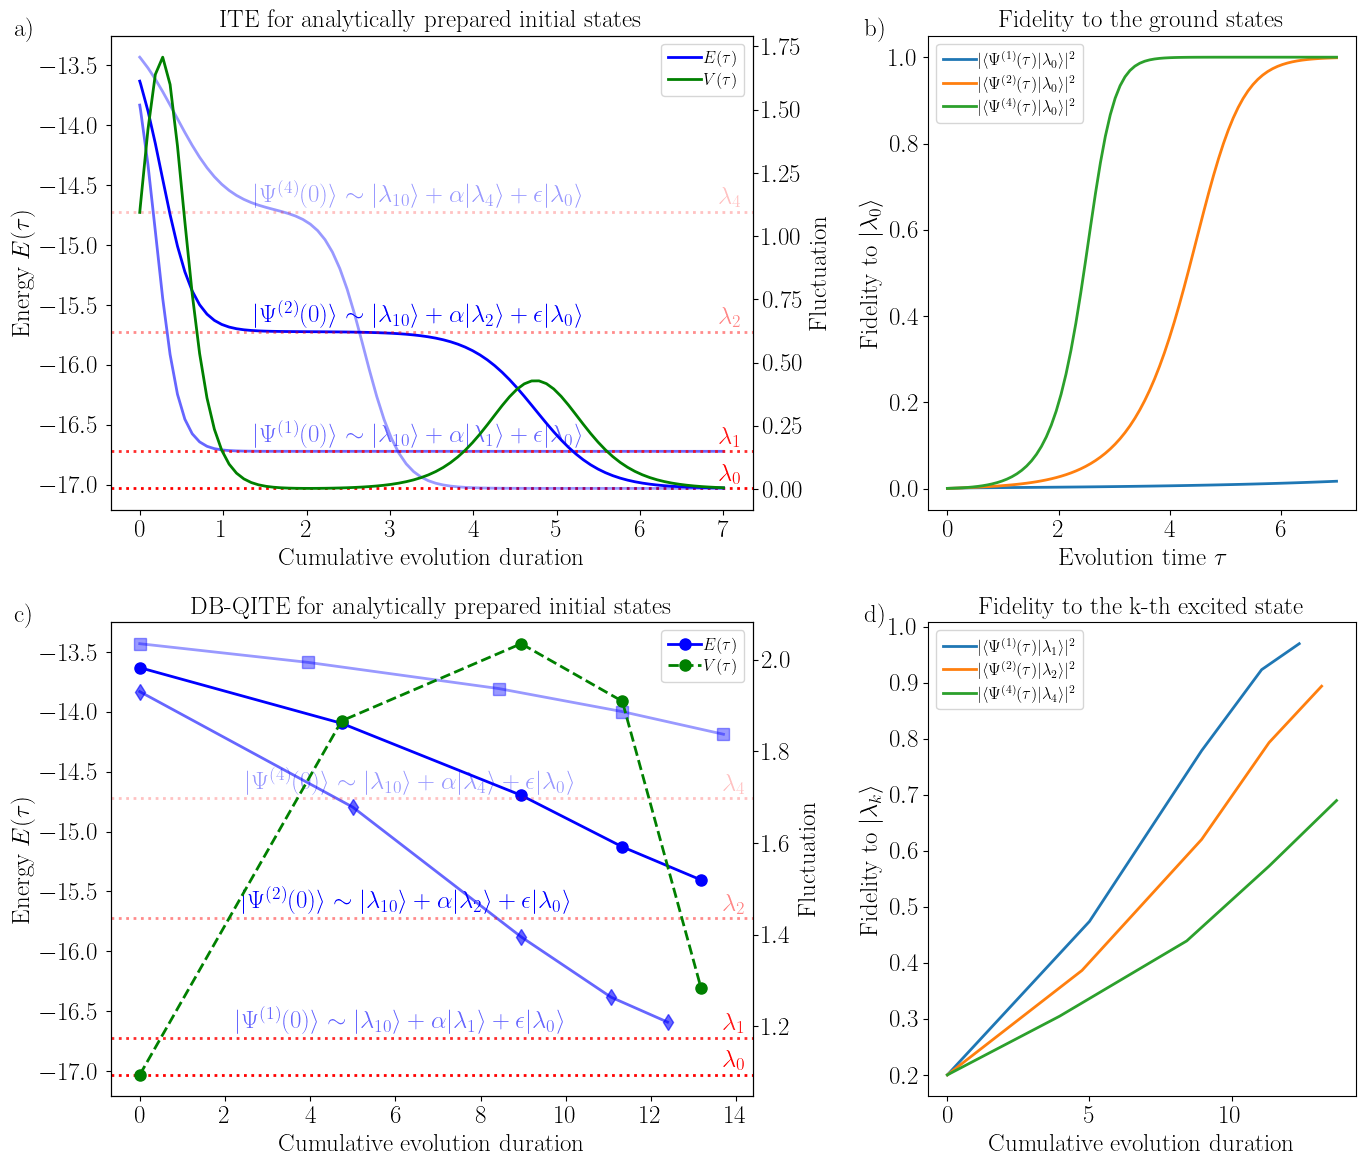

In [15]:
# Create a figure with 2 subplots side-by-side
#fig, (ax_energy, ax_fidelity) = plt.subplots(1, 2, 
#                                             figsize=(14, 6),
#                                             gridspec_kw={"width_ratios":[1.5,1]})

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, ((ax_energy1, ax_fidelity1), (ax_energy2, ax_fidelity2)) = plt.subplots(2, 2, 
                                             figsize=(14, 12), 
                                             gridspec_kw={"width_ratios": [1.5, 1], "height_ratios": [1,1]})
a = -0.15
b = 1.0
ax_energy1.annotate('a)', xy = (a,b), xycoords='axes fraction')
ax_fidelity1.annotate('b)', xy = (a,b), xycoords='axes fraction')
ax_energy2.annotate('c)', xy = (a,b), xycoords='axes fraction')
ax_fidelity2.annotate('d)', xy = (a,b), xycoords='axes fraction')

###############################################################################
# SUBPLOT 1: Energy + fluctuation (with a twin y-axis) ITE
###############################################################################
ax1 = ax_energy1  # rename for clarity

# Plot a horizontal line for the ground-state energy
ax1.axline((beta_list[0], eigvals_sorted[0]), 
           (beta_list[-1], eigvals_sorted[0]), 
           linestyle=":", color="red")
ax1.text(
    beta_list[-1]-0.05,           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$\lambda_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)

alphas = [0.6, 1, 0.4]

# Plot energies for each mid_id
for i, mid_id in enumerate(mid_id_ls):
    # Possibly highlight mid_id=2 with a label
    if mid_id == 2:
        line1, = ax1.plot(
            beta_list, 
            energy_dict[mid_id], 
            # label=rf"$\langle \psi^{{{mid_id}}}(\tau)|\hat H|\psi_{{{mid_id}}}(\tau)\rangle$", 
            label=rf"$E(\tau)$",
            color="blue", 
            alpha=alphas[i]
        )
    else:
        line1, = ax1.plot(
            beta_list, 
            energy_dict[mid_id], 
            color="blue", 
            alpha=alphas[i]
        )

    # Annotations on each line (example)
    ax1.text(
        beta_list[-1]/6 + 0.2, 
        eigvals_sorted[mid_id]+0.15,
        rf"$|\Psi^{{({mid_id})}}(0)\rangle \sim |\lambda_{{10}}\rangle + \alpha |\lambda_{{{mid_id}}}\rangle + \epsilon |\lambda_0\rangle$",
        va="center",
        ha="left",
        color="blue",
        alpha=alphas[i]
    )

    # Horizontal line for the mid_id'th eigenvalue
    ax1.axline(
        (beta_list[0], eigvals_sorted[mid_id]),
        (beta_list[-1], eigvals_sorted[mid_id]),
        linestyle=":",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.2)
    )

    ax1.text(
        beta_list[-1]-0.05,
        eigvals_sorted[mid_id] + 0.12,
        f"$\lambda_{mid_id}$",
        va="center",
        ha="left",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.1)
    )

ax1.set_xlabel("Cumulative evolution duration")
ax1.set_ylabel(r"Energy $E(\tau)$")

# Create a twin axis for fluctuation
ax2 = ax1.twinx()
line2, = ax2.plot(
    beta_list, 
    fluctuation_dict[2],
    # label=r"$\langle \psi_2(\tau)|(\hat H-E(\tau))^2|\psi_2(\tau)\rangle$",
    label=r"$V(\tau)$",
    color="green"
)
ax2.set_ylabel("Fluctuation")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

ax1.set_title('ITE for analytically prepared initial states')

###############################################################################
# SUBPLOT 2: Fidelity to the ground state
###############################################################################
axF = ax_fidelity1

# Plot fidelity for each mid_id (example)
for i, mid_id in enumerate(mid_id_ls):
    lineF, = axF.plot(
        beta_list, fidelity_dict[mid_id],
        label=rf"$|\langle\Psi^{{({mid_id})}}(\tau)|\lambda_0\rangle|^2$",
    )

axF.set_xlabel(r"Evolution time $\tau$")
axF.set_ylabel(r"Fidelity to $|\lambda_0\rangle$")

axF.legend(loc="best")

axF.set_title('Fidelity to the ground states')


###############################################################################
# SUBPLOT 3: Energy + fluctuation (with a twin y-axis) QITE
###############################################################################
ax3 = ax_energy2  # rename for clarity

# Plot a horizontal line for the ground-state energy
ax3.axhline(y=eigvals_sorted[0], color="red", linestyle=':')

ax3.text(
    beta_max_qite,           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$\lambda_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)

alphas = [0.6, 1, 0.4]
markers = ['d','o','s']

# Plot energies for each mid_id
for i, mid_id in enumerate(mid_id_ls):
    # Possibly highlight mid_id=2 with a label
    if mid_id == 2:
        line1, = ax3.plot(
            beta_lists_qite[mid_id], 
            energy_dict_qite[mid_id], 
            # label=rf"$\langle \psi^{{{mid_id}}}(\tau)|\hat H|\psi_{{{mid_id}}}(\tau)\rangle$", 
            label=rf"$E(\tau)$",
            color="blue", 
            marker = markers[i],
            alpha=alphas[i]
        )
    else:
        line1, = ax3.plot(
            beta_lists_qite[mid_id], 
            energy_dict_qite[mid_id], 
            color="blue", 
            marker = markers[i],
            alpha=alphas[i]
        )

    # Annotations on each line (example)
    ax3.text(
        beta_lists_qite[mid_id][-1]/6 + 0.2, 
        eigvals_sorted[mid_id]+0.15,
        rf"$|\Psi^{{({mid_id})}}(0)\rangle \sim |\lambda_{{10}}\rangle + \alpha |\lambda_{mid_id}\rangle + \epsilon |\lambda_0\rangle$",
        va="center",
        ha="left",
        color="blue",
        alpha=alphas[i]
    )

    # Horizontal line for the mid_id'th eigenvalue
    ax3.axhline(y=eigvals_sorted[mid_id], color="red", linestyle=':', alpha=1.0 / (int(mid_id) + 0.2))

    ax3.text(
        beta_max_qite,
        eigvals_sorted[mid_id] + 0.12,
        f"$\lambda_{mid_id}$",
        va="center",
        ha="left",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.1)
    )

ax3.set_xlabel("Cumulative evolution duration")
ax3.set_ylabel(r"Energy $E(\tau)$")

# Create a twin axis for fluctuation
ax4 = ax3.twinx()
for i, mid_id in enumerate(mid_id_ls):
    if mid_id==2:
        line2, = ax4.plot(
            beta_lists_qite[mid_id], 
            fluctuation_dict_qite[mid_id],
            # label=r"$\langle \psi_2(\tau)|(\hat H-E(\tau))^2|\psi_2(\tau)\rangle$",
            label=r"$V(\tau)$",
            color="green",
            linestyle='dashed',
            marker=markers[i]
        )
ax4.set_ylabel("Fluctuation")

# Combine legends from both axes
lines_1, labels_1 = ax3.get_legend_handles_labels()
lines_2, labels_2 = ax4.get_legend_handles_labels()
ax3.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

ax3.set_title('DB-QITE for analytically prepared initial states')

###############################################################################
# SUBPLOT 4: Fidelity to the ground state
###############################################################################
axF2 = ax_fidelity2

# Plot fidelity for each mid_id (example)
for i, mid_id in enumerate(mid_id_ls):
    lineF, = axF2.plot(
        beta_lists_qite[mid_id], fidelity_dict_qite[mid_id],
        label=rf"$|\langle\Psi^{{({mid_id})}}(\tau)|\lambda_{{{mid_id}}}\rangle|^2$",
    )

axF2.set_xlabel("Cumulative evolution duration")
axF2.set_ylabel(r"Fidelity to $|\lambda_k\rangle$")

axF2.legend(loc="best")

axF2.set_title('Fidelity to the k-th excited state')

###############################################################################
###############################################################################

plt.tight_layout()
plt.savefig("plots/QITE_analytical.pdf")
plt.show()